In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


In [2]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets


In [3]:
# загрузка пакетов: модели -------------------------------------------------
# стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# константы
# ядро для генератора случайных чисел
my_seed = 13
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков: 
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [5]:
def plot_coeffs_traces(X, y, class_number, penalty_name, C_opt, col_names, C_min_pow=-4, C_max_pow=3.):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)

    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, C=10**c, solver='liblinear', multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)
    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column], label=col_names[column], color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**C_min_pow, 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
    plt.show()




In [6]:
fileURL = "https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv"
DF_all = pd.read_csv(fileURL)
# загружаем таблицу и превращаем её во фрейм
#DF_all = datasets.load_vine(as_frame=True)['frame']
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)



Число строк и столбцов в наборе данных:
 (30000, 24)


In [7]:
#DF_all.drop(['Y'], axis=1, inplace=True)
# наблюдения для моделирования
DF = DF_all.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)
# первые 5 строк фрейма у первых 7 столбцов
DF.iloc[:, :7].head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2
3195,20000,1,3,2,39,0,0
15960,300000,2,1,2,30,0,0
17713,120000,2,1,2,30,0,0
17897,110000,1,1,2,27,0,0
23049,200000,2,1,1,41,1,-1


In [8]:
# первые 5 строк фрейма у столбцов 8-11
DF.iloc[:, 7:11].head(5)

,PAY_3,PAY_4,PAY_5,PAY_6
3195,0,0,2,2
15960,0,0,0,0
17713,0,0,0,0
17897,0,0,0,0
23049,0,-1,2,0


In [9]:
# первые 5 строк фрейма у столбцов 12-14
DF.iloc[:, 11:].head(5)

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
3195,7824,9000,9867,11929,12091,12245,1307,1174,2236,500,500,0,0
15960,217329,206703,203164,164371,161331,154515,8000,20219,7500,6500,7500,6000,0
17713,170263,157881,160796,160168,156165,158850,5520,5700,5815,5500,5522,6000,0
17897,87487,90120,93661,96185,99667,102978,5000,5000,5000,5000,5000,4000,0
23049,2217,61328,2877,160944,156864,160066,61634,2877,160944,0,5900,13000,1


In [10]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

In [11]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

In [12]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [13]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.781
1    0.219
Name: Y, dtype: float64

In [14]:
# описательные статистики
DF.iloc[:, :6].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,167848.614902,1.604510,1.854078,1.551137,35.473647,-0.019294
std,129894.926164,0.488965,0.791689,0.521709,9.224644,1.125633
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000


In [15]:
# описательные статистики
DF.iloc[:, 6:11].describe()

,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,-0.136745,-0.171020,-0.226353,-0.272706,-0.295529
std,1.197933,1.193489,1.167079,1.131698,1.151099
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000


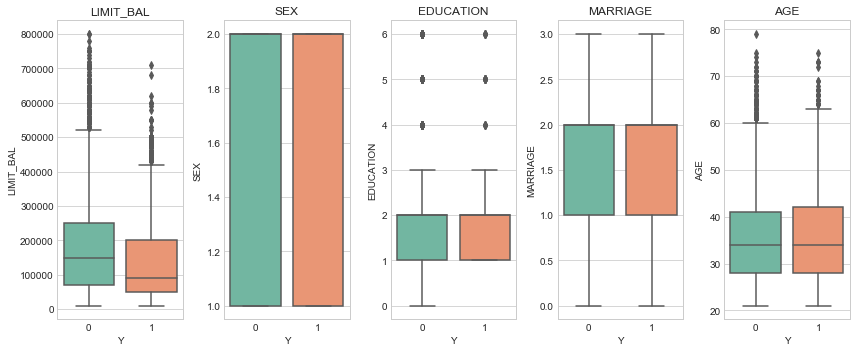

In [16]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
    
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

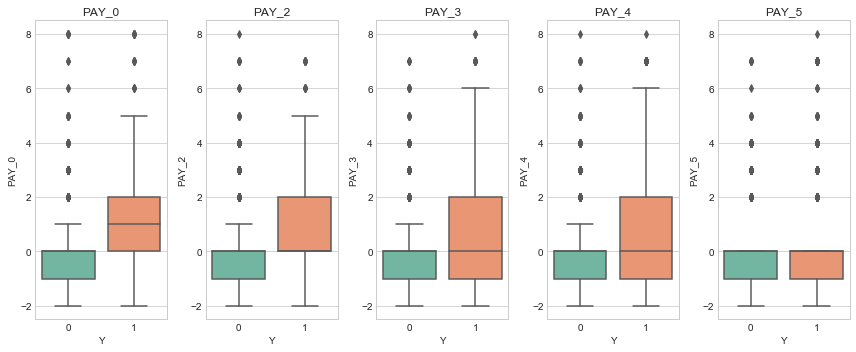

In [17]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

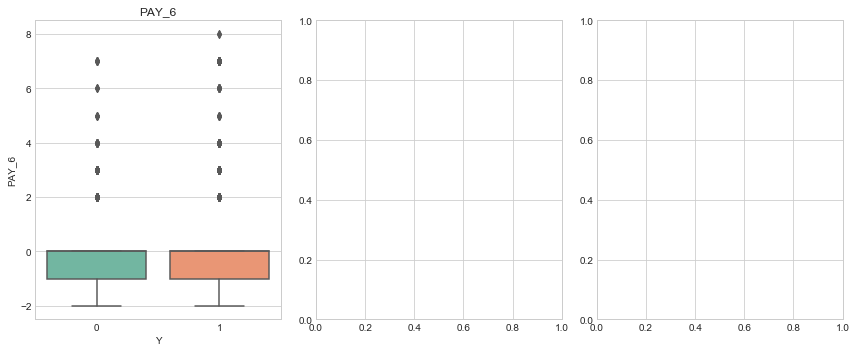

In [19]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
axs = [ax1, ax2, ax3]
cols_loop = list(DF.columns[10:11].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

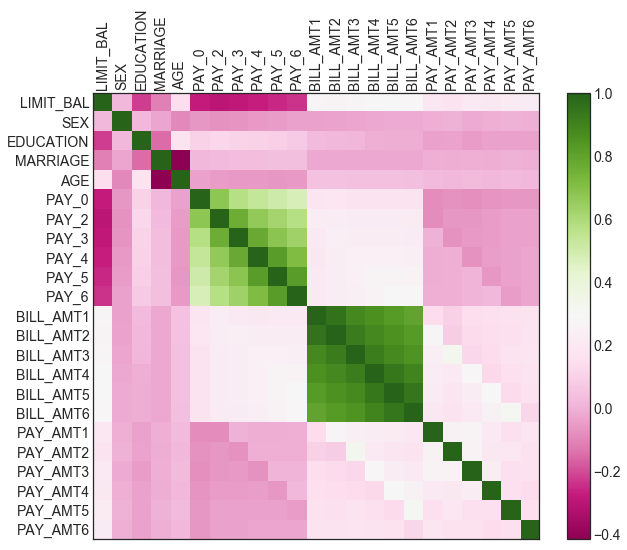

In [20]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns
# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')
# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

In [21]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
# и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
# корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
# выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
63,MARRIAGE,AGE,-0.415966,0.0
5,LIMIT_BAL,PAY_2,-0.299018,0.0
6,LIMIT_BAL,PAY_3,-0.288579,0.0
4,LIMIT_BAL,PAY_0,-0.274504,0.0
7,LIMIT_BAL,PAY_4,-0.268215,0.0
8,LIMIT_BAL,PAY_5,-0.250054,0.0
9,LIMIT_BAL,PAY_6,-0.237682,0.0
1,LIMIT_BAL,EDUCATION,-0.216946,0.0
43,EDUCATION,MARRIAGE,-0.145674,0.0
2,LIMIT_BAL,MARRIAGE,-0.108482,0.0


In [22]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :11].values)
# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
 print('Столбец ', i_col, ': среднее = ',
 np.round(np.mean(X_train_std[:, i_col]), 2),
 ' Станд. отклонение = ',
 np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0 Станд. отклонение = 1.0
Столбец 1: среднее = 0.0 Станд. отклонение = 1.0
Столбец 2: среднее = -0.0 Станд. отклонение = 1.0
Столбец 3: среднее = -0.0 Станд. отклонение = 1.0
Столбец 4: среднее = -0.0 Станд. отклонение = 1.0
Столбец 5: среднее = -0.0 Станд. отклонение = 1.0
Столбец 6: среднее = 0.0 Станд. отклонение = 1.0
Столбец 7: среднее = -0.0 Станд. отклонение = 1.0
Столбец 8: среднее = 0.0 Станд. отклонение = 1.0
Столбец 9: среднее = -0.0 Станд. отклонение = 1.0
Столбец 10: среднее = 0.0 Станд. отклонение = 1.0


C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
# функция с методом главных компонент
pca = PCA()
# пересчитываем в главные компоненты (ГК)
X_train_pca = pca.fit_transform(X_train_std)
# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
 np.around(frac_var_expl, 3),
 '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.406 0.139 0.1   0.091 0.064 0.059 0.051 0.037 0.024 0.018 0.012] 
Общая сумма долей: 1.0


In [24]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)


,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
1,0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
2,-0.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0
3,0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
4,0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
5,0.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0
6,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0
7,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0
8,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,-0.0
9,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,0.0


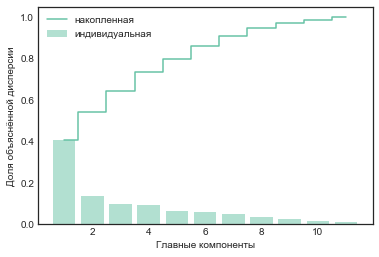

In [34]:
# график объяснённой дисперсии
plt.bar(range(1, 12), pca.explained_variance_ratio_, alpha=0.5, align='center', label='индивидуальная')
plt.step(range(1, 12), np.cumsum(pca.explained_variance_ratio_),
 where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()




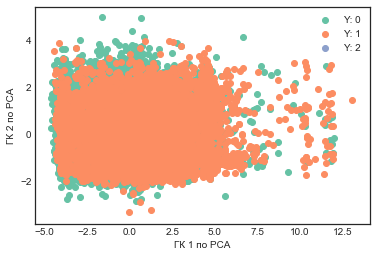

In [36]:
# пересчитываем X в 2 ГК
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
# график классов в пространстве ГК
plt.scatter(X_train_pca[DF['Y'] == 0][:, 0],
 X_train_pca[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0],
 X_train_pca[DF['Y'] == 1][:, 1], label='Y: 1')
plt.scatter(X_train_pca[DF['Y'] == 2][:, 0],
 X_train_pca[DF['Y'] == 2][:, 1], label='Y: 2')
plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.legend()
plt.show()

In [38]:
# функция оценки логистической регрессии
logit = LogisticRegression()
# функция разбиения на блоки для перекрёстной проверки
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_10,
 scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
 '\nAcc = ', np.around(score[0], 2), sep='')


C:\Anaconda\envs\env01\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.8


In [67]:
Y_train = pd.get_dummies(DF[["Y"]].astype(str))
Y_train = Y_train.drop('Y_1', axis=1)
print(Y_train.head())
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
print(X_train_std.shape)
print(Y_train.shape)
logit_ridge.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),
 '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))


       Y_0
3195     1
15960    1
17713    1
17897    1
23049    0
(25500, 11)
(25500, 1)
Константы моделей для классов:
 [1.455] 
Коэффициенты моделей для классов:
 [[ 0.238  0.049  0.092  0.079 -0.08  -0.662 -0.093 -0.08  -0.016 -0.039
   0.009]]


C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
# поиск оптимального значения C:
# подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2,
 penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
# точность для каждого класса
ridge_cv.C_


C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2.7825594])

In [70]:
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')

if len(score_models) > 2 and len(score) > 2: # Проверяем, что списки содержат нужное количество элементов
    print('Модель ', score_models[2], ', перекрёстная проверка по 10 блокам',
     '\nAcc = ', score[2], sep='')
else:
    print("Не достаточно элементов в списках для обращения по индексу")


Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.812


C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

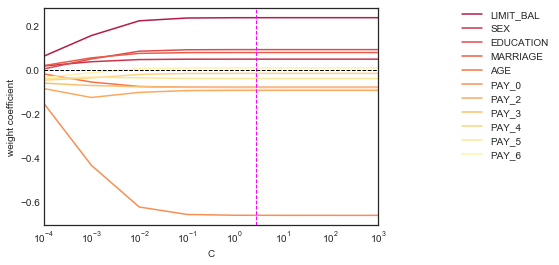

In [71]:
# график динамики коэффициентов в ридж-регрессии 
# модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)


C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

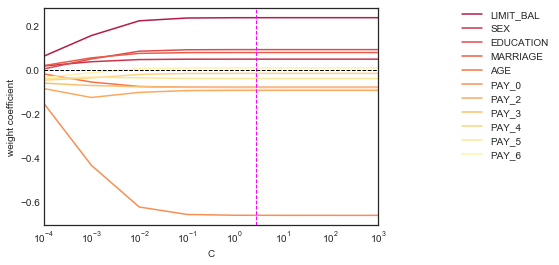

In [73]:
# график динамики коэффициентов в ридж-регрессии 
# модель для класса 1
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)


C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

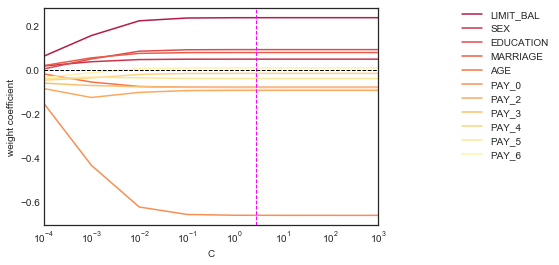

In [74]:
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)


In [75]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Acc,Модель
0,0.799,logit_PC2
1,0.812,logit_ridge
2,0.812,logit_ridge


In [83]:
from sklearn.preprocessing import StandardScaler

# Инициализация нового StandardScaler
sc_pred = StandardScaler()

# Обучение StandardScaler на обучающих данных
sc_pred.fit(DF.iloc[:, :11].values)

# Применение StandardScaler к данным для предсказания
X_pred_std = sc_pred.transform(DF_predict.iloc[:, :11].values)

# Предсказание с использованием модели
Y_hat = logit_ridge.predict(X_pred_std)

# Отчет по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))





              precision    recall  f1-score   support

           0       0.28      0.03      0.05      3454
           1       0.19      0.77      0.31      1046

   micro avg       0.20      0.20      0.20      4500
   macro avg       0.24      0.40      0.18      4500
weighted avg       0.26      0.20      0.11      4500



C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\envs\env01\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
